# Exploratory Data Analysis
    
The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics.

- The **training data** is a single, continuous segment of experimental data.
    - **acoustic_data** the seismic signal [int16]
    - **time_to_failure** the time (in seconds) until the next laboratory earthquake [float64]
- The **test data** consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.
    - **seg_id** the test segment id for wich predictions should be made (one prediction per segment)

For each *seg_id* in the test folder, you should predict a single *time_to_failure* corresponding to the time between the last row of the segment and the next laboratory earthquake.

[Scores](https://docs.google.com/spreadsheets/d/1AWLPZfryFWx6wM9fxmMmGm31R4B9PMrZzLp71ZtlcRk/edit#gid=0)

In [1]:
# Convenience
import warnings
from tqdm import tqdm
from tqdm import tqdm_notebook

import random
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import NuSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Machine Learning libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from sklearn import model_selection
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, roc_curve, auc

# Signal processing
from scipy import stats
from scipy.signal import hann
from scipy.signal import hilbert
from scipy.signal import convolve

warnings.filterwarnings("ignore")

random.seed(1)

pd.options.display.precision = 15
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.options.display.width = 1000

In [2]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

[Earthquakes FE. More features and samples](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples)<br/>
[Seismic data EDA and baseline](https://www.kaggle.com/artgor/seismic-data-eda-and-baseline)<br/>
[Shaking Earth](https://www.kaggle.com/allunia/shaking-earth)

## Loading data

In [3]:
df_train = pd.read_csv('input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
df_train = reduce_memory_usage(df_train)
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage: 3600.00 MB
Reduced memory usage: 2400.00 MB (33.3% reduction)
629,145,480 records and 2 features in train set.


## Visualizations
Inspired by [Seismic Data Exploration](https://www.kaggle.com/jsaguiar/seismic-data-exploration)

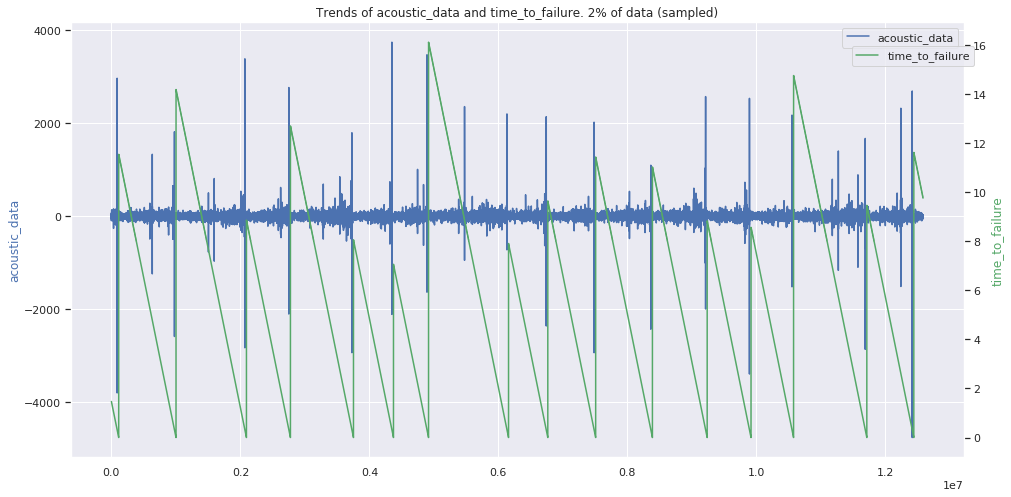

In [29]:
sns.set()
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(df_train['acoustic_data'].values[::50], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(df_train['time_to_failure'].values[::50], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

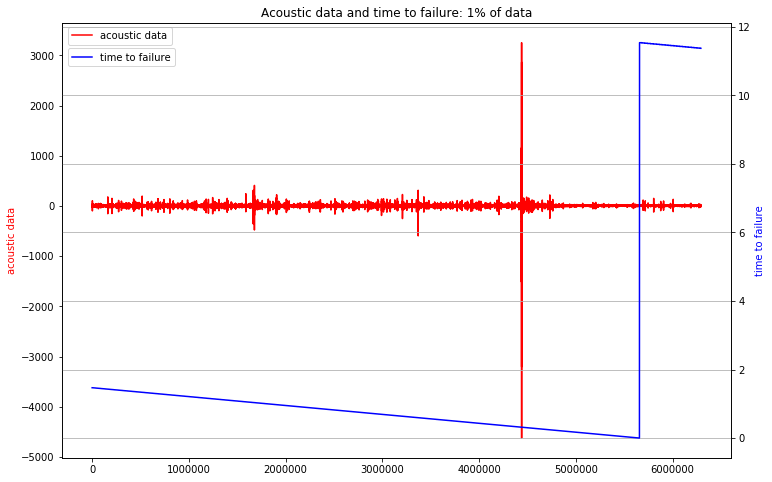

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.title("Acoustic data and time to failure: 1% of data")
plt.plot(df_train['acoustic_data'].values[:6291455], color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))

ax2 = ax1.twinx()
plt.plot(df_train['time_to_failure'].values[:6291455], color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)

In [5]:
train_sample = df_train.sample(frac=0.01)

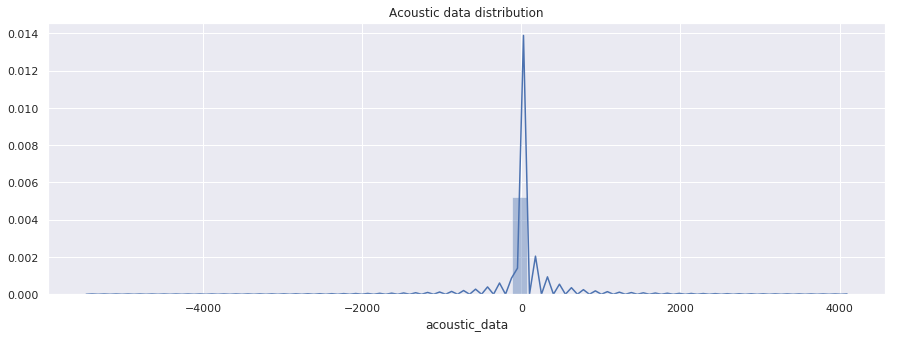

In [30]:
plt.figure(figsize=(15, 5))
plt.title("Acoustic data distribution")
ax = sns.distplot(train_sample.acoustic_data, label='Train (1% sample)')

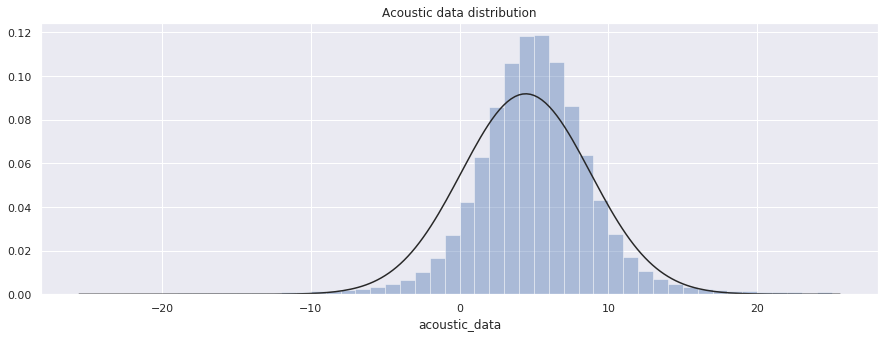

In [31]:
plt.figure(figsize=(15, 5))
plt.title("Acoustic data distribution")
tmp = train_sample.acoustic_data[train_sample.acoustic_data.between(-25, 25)]
ax = sns.distplot(tmp, label='Train (1% sample)', kde=False, fit=stats.norm)

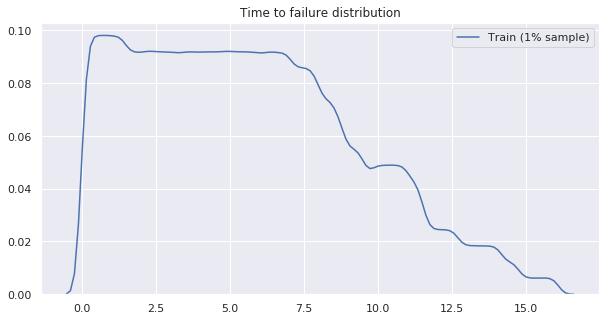

In [32]:
plt.figure(figsize=(10,5))
plt.title("Time to failure distribution")
ax = sns.kdeplot(train_sample.time_to_failure, label='Train (1% sample)')

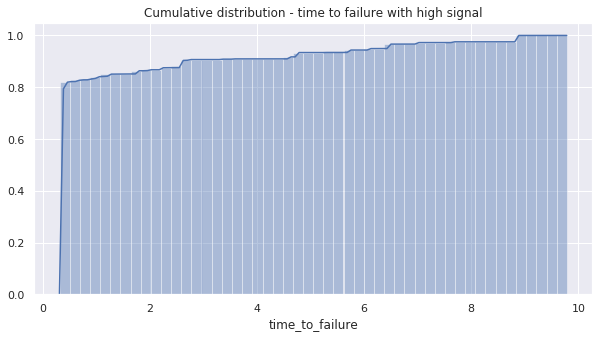

In [33]:
peaks = df_train[df_train.acoustic_data.abs() > 500]

plt.figure(figsize=(10,5))
plt.title("Cumulative distribution - time to failure with high signal")
ax = sns.distplot(peaks.time_to_failure, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

More than 80% of high acoustic values are around 0.31 seconds before an earthquake.

In [14]:
diff = df_train.iloc[:5000000].time_to_failure.diff()
counts = diff.value_counts()

In [17]:
counts

 0.0000000000000    4998759
-0.0009765625000        984
-0.0014648437500         79
-0.0012207031250         78
-0.0010986328125         48
-0.0019531250000         35
-0.0002441406250          7
-0.0004882812500          5
-0.0001220703125          4
Name: time_to_failure, dtype: int64

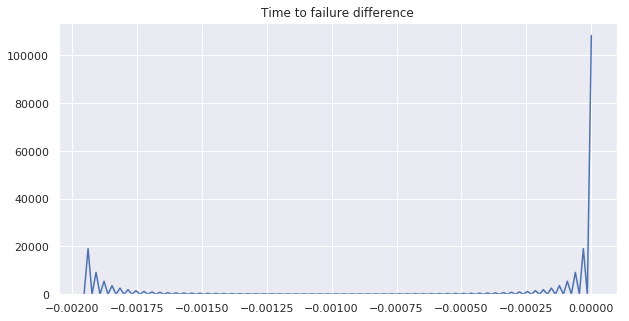

In [34]:
plt.figure(figsize=(10,5))
plt.title("Time to failure difference")
ax = sns.kdeplot(data=diff.values)

Most values are less than 0.0001, but there are a few around 0.0010, which means that there are different time steps.

### Rolling mean & standard

In [23]:
rolling_mean = []
rolling_std = []
last_time = []
init_idx = 0
for _ in range(int(df_train.shape[0]/150000)):
    x = df_train.iloc[init_idx:init_idx + 150000]
    last_time.append(x.time_to_failure.values[-1])
    rolling_mean.append(x.acoustic_data.abs().mean())
    rolling_std.append(x.acoustic_data.abs().std())
    init_idx += 150000
    
rolling_mean = np.array(rolling_mean)
last_time = np.array(last_time)

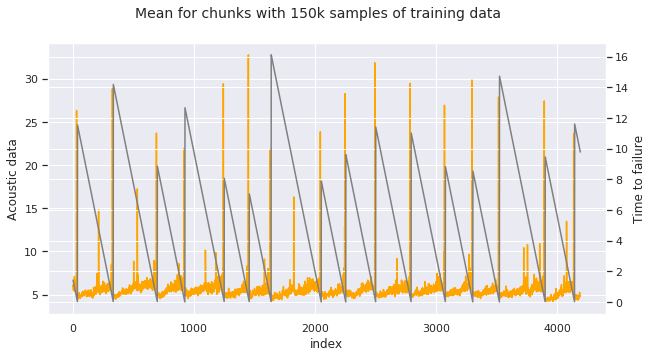

In [35]:
fig, ax1 = plt.subplots(figsize=(10, 5))
fig.suptitle('Mean for chunks with 150k samples of training data', fontsize=14)

ax2 = ax1.twinx()
ax1.set_xlabel('index')
ax1.set_ylabel('Acoustic data')
ax2.set_ylabel('Time to failure')
p1 = sns.lineplot(data=rolling_mean, ax=ax1, color='orange')
p2 = sns.lineplot(data=last_time, ax=ax2, color='gray')

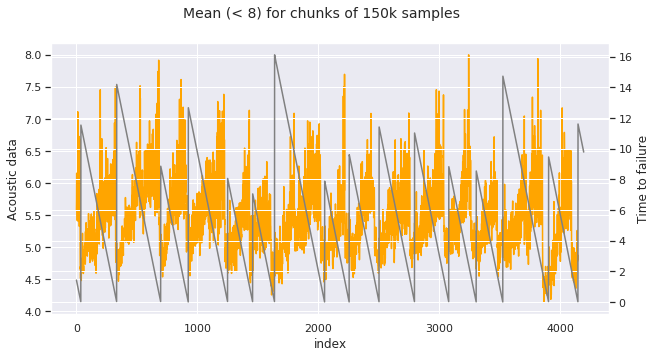

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 5))
fig.suptitle('Mean (< 8) for chunks of 150k samples', fontsize=14)

ax2 = ax1.twinx()
ax1.set_xlabel('index')
ax1.set_ylabel('Acoustic data')
ax2.set_ylabel('Time to failure')
p1 = sns.lineplot(data=rolling_mean[rolling_mean < 8], ax=ax1, color='orange')
p2 = sns.lineplot(data=last_time, ax=ax2, color='gray')

The mean absolute value is increasing as we get closer to an earthquake.

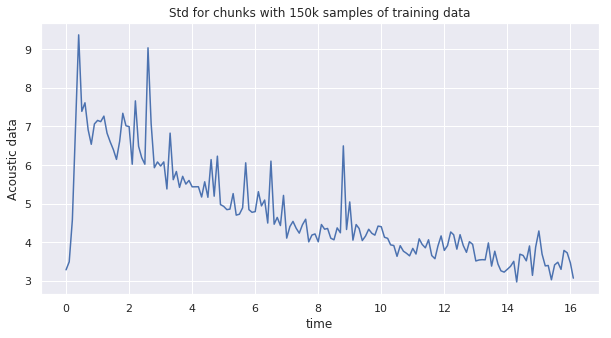

In [37]:
frame = pd.DataFrame({'rolling_std': rolling_std, 'time': np.around(last_time, 1)})
s = frame.groupby('time').rolling_std.mean()
s = s[s < 20]  # remove one outlier
plt.figure(figsize=(10, 5))
plt.title("Std for chunks with 150k samples of training data")
plt.xlabel("Time to failure")
plt.ylabel("Acoustic data")
ax = sns.lineplot(x=s.index, y=s.values)

The standard deviation gets higher for chunks that are closer to an earthquake (in general).

## Feature extraction

### Checking test files

In [83]:
test_file_list = pd.read_csv('input/sample_submission.csv', index_col='seg_id', usecols=['seg_id'])
test_file_sizes = pd.DataFrame(columns=['seg_id', 'records'])
total_number_files = test_file_list.shape[0]
i = 0

for seg_id in test_file_list.index:
    seg = pd.read_csv('input/test/' + seg_id + '.csv')
    test_file_sizes = test_file_sizes.append({'seg_id': seg_id, 'records': seg.shape[0]}, ignore_index=True)
    if (i == int(i/500)*500) or (i == total_number_files-1):
        print('{:,}. of {:,}'.format(i+1, total_number_files))
    
    i = i + 1

0. of 2,624
500. of 2,624
1,000. of 2,624
1,500. of 2,624
2,000. of 2,624
2,500. of 2,624
2,623. of 2,624


In [81]:
test_file_sizes.describe()

,seg_id,records
count,2624,2624
unique,2624,1
top,seg_4c4995,150000
freq,1,2624


The length of all test segments are 150,000. There are no missing elements. 

### Basic feature extraction

In [51]:
df_train[5_656_570:5_656_575]

,acoustic_data,time_to_failure
5656570,2,0.000795364379883
5656571,4,0.000795364379883
5656572,5,0.000795364379883
5656573,4,0.000795364379883
5656574,4,11.539062500000000


In [4]:
rows = 150_000
segments = int(np.floor(df_train.shape[0] / rows))
print('Number of segments: {:,}'.format(segments))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

for segment in tqdm_notebook(range(segments)):
    seg = df_train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()

Number of segments: 4,194


## Training

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

### Nu Support Vector Regression

In [41]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

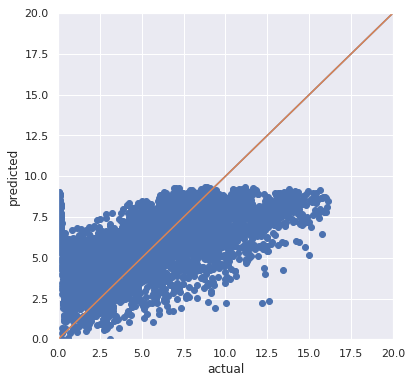

In [42]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [43]:
NuSVR_MAE_score = mean_absolute_error(y_train.values.flatten(), y_pred)
print('MAE: {:.5f}'.format(NuSVR_MAE_score))

MAE: 2.31352


In [ ]:
submission = pd.read_csv('input/sample_submission.csv', index_col='seg_id')

In [ ]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [ ]:
for seg_id in X_test.index:
    seg = pd.read_csv('input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [ ]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('output/NuSVR_MAE{:.5f}.csv'.format(NuSVR_MAE_score))
print('output/NuSVR_MAE{:.5f}.csv'.format(NuSVR_MAE_score))

### Machine Learning Algorithms

In [9]:
MLA = [
    # Linear models
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.Lasso(alpha=0.1),
    linear_model.ElasticNet(),
    linear_model.LassoLars(alpha=.1),
    linear_model.BayesianRidge(),
    linear_model.SGDRegressor(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.RANSACRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.HuberRegressor(),

    # SVR
    NuSVR(),

    # LightGBM
    lgb.LGBMRegressor(learning_rate=0.05, n_estimators = 50000, eval_metric='mae'),
    
    # CatBoost
    CatBoostRegressor(iterations=3000, learning_rate=0.03, eval_metric='MAE', verbose=False)
]

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .25, train_size = .75, random_state = 0)

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = X_train

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print(MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train_scaled, y_train, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train_scaled, y_train)
    MLA_predict[MLA_name] = alg.predict(X_train_scaled)

    row_index+=1

#MLA_compare['MLA Test Accuracy Mean'] = MLA_compare['MLA Test Accuracy Mean'].abs()
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = True, inplace = True)

LinearRegression
Ridge
Lasso
ElasticNet
LassoLars
BayesianRidge
SGDRegressor
PassiveAggressiveRegressor
RANSACRegressor
TheilSenRegressor
HuberRegressor
NuSVR
LGBMRegressor
CatBoostRegressor


In [10]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
8,RANSACRegressor,"{'base_estimator': None, 'is_data_valid': None...",-7.73113645763053,-7.33111914198386,17.0633467851714,0.0784567356109619
9,TheilSenRegressor,"{'copy_X': True, 'fit_intercept': True, 'max_i...",-7.38255842418993,-6.66448347789017,11.3513822386603,1.59113483428955
7,PassiveAggressiveRegressor,"{'C': 1.0, 'average': False, 'early_stopping':...",-5.00528788634434,-4.1821574199759,5.61361006887744,0.00401310920715332
10,HuberRegressor,"{'alpha': 0.0001, 'epsilon': 1.35, 'fit_interc...",-0.353129781037742,-0.508216818018665,2.06447191889115,0.0216593503952026
4,LassoLars,"{'alpha': 0.1, 'copy_X': True, 'eps': 2.220446...",0,-0.00218488196973265,0.00761095952837273,0.00477504730224609
3,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.021363994143529,0.0187072634394731,0.00702195455703102,0.00483529567718506
12,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",0.999739728574138,0.0327800841828143,0.0920442120169985,56.1164459705353
6,SGDRegressor,"{'alpha': 0.0001, 'average': False, 'early_sto...",0.0463409878456276,0.0413014869461388,0.040524096061919,0.00630133152008057
2,Lasso,"{'alpha': 0.1, 'copy_X': True, 'fit_intercept'...",0.046451487991976,0.0436330747378471,0.0173717666325946,0.0052664041519165
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.0551705636178839,0.0441709104981262,0.059517092073804,0.00654089450836182


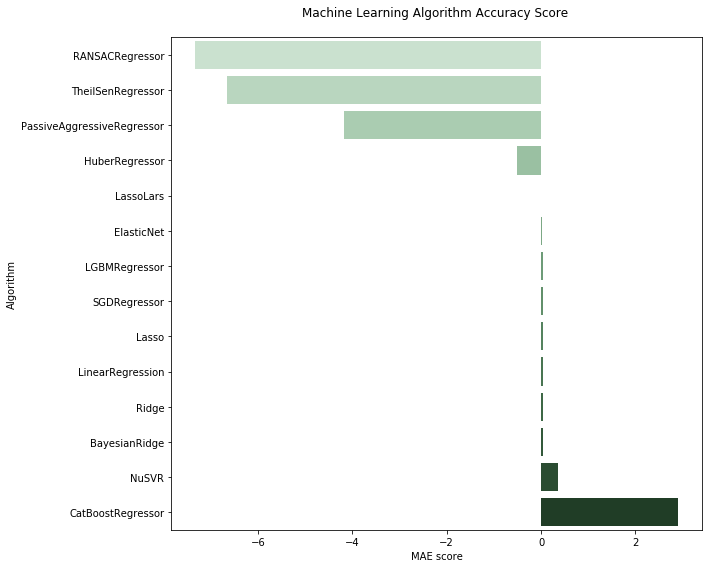

In [11]:
plt.figure(figsize=(10, 8))
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, palette=sns.cubehelix_palette(len(MLA_compare), start=2, rot=0, dark=0.2, light=.85, reverse=False))

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('MAE score')
plt.ylabel('Algorithm')
plt.tight_layout()

### GridSearch
[Using Grid Search to Optimise CatBoost Parameters](https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html)

In [ ]:
model_cb = CatBoostRegressor(eval_metric='MAE', loss_function='MAE', verbose=False, learning_rate=0.03)
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.25, train_size=.75, random_state=1)
base_results = model_selection.cross_validate(model_cb, X_train_scaled, y_train, cv=cv_split)
model_cb.fit(X_train, y_train)

print('BEFORE DT Parameters: ', model_cb.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

param_grid = {
    #'iterations': [100, 500],
    'depth': [8, 16],
    #'l2_leaf_reg': [3, 10],
    #'border_count': [32, 64]
}

tune_model = model_selection.GridSearchCV(CatBoostRegressor(eval_metric='MAE', loss_function='MAE', learning_rate=0.03), param_grid=param_grid, scoring = 'neg_mean_absolute_error', cv = cv_split, verbose=1, n_jobs=4)
tune_model.fit(X_train_scaled, y_train)

print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))

### Bayesian optimization

In [ ]:
train_data = lgb.Dataset(data=X_train_scaled, label=y_train, free_raw_data=False)

def lgb_eval(num_leaves, feature_fraction, max_depth, min_split_gain, min_child_weight, bagging_freq, reg_alpha, reg_lambda):
    params = {
        "objective": "regression",
        "bagging_fraction": 0.8,
        "min_child_samples": 20,
        "boosting": "gbdt",
        "learning_rate": 0.01,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "verbosity": -1,
        "metric": 'mae'
    }

    params["bagging_freq"] = int(round(bagging_freq))
    params["reg_alpha"] = reg_alpha
    params["reg_lambda"] = reg_lambda
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['num_leaves'] = int(round(num_leaves))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight

    cv_result = lgb.cv(params, train_data, nfold=5, seed=123, verbose_eval=200, stratified=False)
    return (-1.0 * np.array(cv_result['l1-mean'])).max()

In [ ]:
lgbBO = BayesianOptimization(lgb_eval, {
    'num_leaves': (24, 80),
    'feature_fraction': (0.1, 1),
    'max_depth': (2, 30),
    'min_split_gain': (0.001, 1),
    'min_child_weight': (1, 30),
    "reg_alpha": (0, 3),
    "reg_lambda": (0, 3),
    "bagging_freq": (1, 10)
})

In [ ]:
lgbBO.maximize(init_points=5, n_iter=15, acq='ei')

### Submission

In [12]:
def create_submission(model, output_filename, mae_score):
    submission = pd.read_csv('input/sample_submission.csv', index_col='seg_id')
    output = pd.DataFrame(columns=['ave', 'std', 'max', 'min'], dtype=np.float64, index=submission.index)
    for seg_id in output.index:
        seg = pd.read_csv('input/test/' + seg_id + '.csv')
        x = seg['acoustic_data'].values

        output.loc[seg_id, 'ave'] = x.mean()
        output.loc[seg_id, 'std'] = x.std()
        output.loc[seg_id, 'max'] = x.max()
        output.loc[seg_id, 'min'] = x.min()

    output_scaled = scaler.transform(output)

    submission['time_to_failure'] = model.predict(output_scaled)
    submission.to_csv(output_filename.format(mae_score))
    print(output_filename.format(mae_score))

In [14]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.05, n_estimatorsu=50000, eval_metric='mae')
model_lgb.fit(X_train_scaled, y_train.values.flatten())
y_pred = model_lgb.predict(X_train_scaled)
mae_score = mean_absolute_error(y_train.values.flatten(), y_pred)

create_submission(model_lgb, 'output/LGBM_MAE{:.5f}.csv', mae_score)

output/LGBM_MAE0.00164.csv
